In [58]:
import tensorflow as tf
import keras
import transformers
from transformers import DistilBertTokenizerFast
import matplotlib.pyplot as plt
from statistics import mean
import os
import csv
import random
import operator
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import re

In [4]:
import json
comments = []
labels = []

with open(os.path.join(os.getcwd(),'data/sarcasm.json')) as file:
    data = json.load(file)
    comments_labels = [(row['is_sarcastic'], row['headline']) for row in data]

In [5]:
comments_labels

[(0,
  "former versace store clerk sues over secret 'black code' for minority shoppers"),
 (0,
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse"),
 (1,
  "mom starting to fear son's web series closest thing she will have to grandchild"),
 (1,
  'boehner just wants wife to listen, not come up with alternative debt-reduction ideas'),
 (0, 'j.k. rowling wishes snape happy birthday in the most magical way'),
 (0, "advancing the world's women"),
 (0, 'the fascinating case for eating lab-grown meat'),
 (0, 'this ceo will send your kids to school, if you work for his company'),
 (1, 'top snake handler leaves sinking huckabee campaign'),
 (0, "friday's morning email: inside trump's presser for the ages"),
 (0, 'airline passengers tackle man who rushes cockpit in bomb threat'),
 (0, 'facebook reportedly working on healthcare features and apps'),
 (0, "north korea praises trump and urges us voters to reject 'dull hillary'"),
 (0, "actually, cnn's jeffrey lo

In [6]:
train_data = comments_labels[:int((len(comments_labels)+1)*.80)]
validation_data = comments_labels[int(len(comments_labels)*.80+1):]

In [11]:
train_data[:5]

[(0,
  "former versace store clerk sues over secret 'black code' for minority shoppers"),
 (0,
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse"),
 (1,
  "mom starting to fear son's web series closest thing she will have to grandchild"),
 (1,
  'boehner just wants wife to listen, not come up with alternative debt-reduction ideas'),
 (0, 'j.k. rowling wishes snape happy birthday in the most magical way')]

# Term Frequency

In [ ]:
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem

In [65]:
def term_frequency(comments_labels):
    nltk.download("stopwords", quiet=True)
    just_sentences = [sentence for label, sentence in comments_labels]    
    tf_dict = {}
    for sentence in just_sentences:
        sentence = re.sub(r"[^a-zA-Z]", " ", sentence.lower())
        split_words = sentence.split(" ")
        for word in split_words:
            if word not in stopwords.words("english") and str(word) not in ['nan', '']:
                tf_dict[word] = tf_dict.setdefault(word, 0) + 1
    return sorted(tf_dict.items(), key=operator.itemgetter(1),reverse=True)

In [66]:
term_frequency = term_frequency(train_data)

In [67]:
term_frequency

[('trump', 1352),
 ('new', 1225),
 ('man', 1116),
 ('year', 442),
 ('one', 429),
 ('report', 402),
 ('area', 392),
 ('woman', 385),
 ('donald', 383),
 ('day', 373),
 ('u', 370),
 ('says', 360),
 ('time', 353),
 ('first', 347),
 ('get', 328),
 ('obama', 327),
 ('like', 322),
 ('women', 317),
 ('old', 315),
 ('life', 305),
 ('world', 303),
 ('people', 303),
 ('nation', 285),
 ('house', 274),
 ('clinton', 271),
 ('back', 264),
 ('white', 260),
 ('still', 255),
 ('make', 254),
 ('americans', 231),
 ('could', 230),
 ('way', 225),
 ('family', 225),
 ('gop', 215),
 ('black', 214),
 ('study', 213),
 ('president', 203),
 ('best', 199),
 ('show', 198),
 ('bill', 198),
 ('school', 195),
 ('years', 194),
 ('would', 193),
 ('american', 191),
 ('watch', 191),
 ('america', 190),
 ('really', 187),
 ('police', 186),
 ('things', 183),
 ('know', 182),
 ('death', 181),
 ('video', 181),
 ('good', 181),
 ('finds', 181),
 ('going', 180),
 ('state', 180),
 ('hillary', 179),
 ('last', 179),
 ('love', 177),
 ('

In [68]:
li = [y for x,y in term_frequency[:10]]
lii = [x for x,y in term_frequency[:10]]

In [55]:
lii

['new',
 'man',
 'trump',
 'area',
 'one',
 'donald',
 'says',
 'woman',
 'u.s.',
 'get']

<BarContainer object of 10 artists>

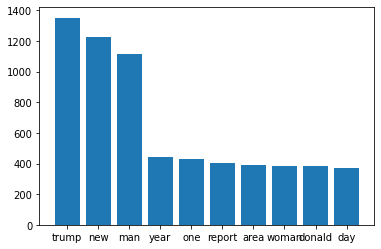

In [69]:
plt.bar(lii, li)

In [8]:
def preprocessing(comments_labels):
    import re
    sentences = [(te, te1) for te, te1 in comments_labels if str(te) not in ['nan', '']]
    reduced_sentences = [(te, te1) for te, te1 in sentences if len(te1.split(" ")) >= 5]
    new_sentences = [(te,re.sub(r"[^a-zA-Z0-9]", " ", te1.lower())) for te, te1 in reduced_sentences]
    return [te1 for te, te1 in new_sentences], [int(te) for te, te1 in new_sentences]

In [9]:
train_text, train_labels = preprocessing(train_data)
validation_text, validation_labels = preprocessing(validation_data)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_text, truncation = True, padding = True, max_length = 50)
validation_encodings = tokenizer(validation_text, truncation = True, padding = True, max_length = 50)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    validation_labels
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [ ]:
val_dataset

In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16),
                    validation_data=val_dataset,
                    epochs=3, batch_size=16,
                    verbose=1)

In [ ]:
history.history